# Landelino Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import shutil
import json
import sys
from scipy.misc import imresize

%matplotlib inline

### Print Versions

In [2]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.7 (v3.6.7:6ec5cf24b7, Oct 20 2018, 13:35:33) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.15.4
matplotlib version: 3.0.2
flopy version: 3.2.10


### Setup folder where modflow-files are located

In [3]:
central_base_model_path = os.path.join('central-base-model')
landelino_model_path = os.path.join('landelino-model')

In [4]:
if os.path.exists(landelino_model_path):
    shutil.rmtree(landelino_model_path)
    
if not os.path.exists(landelino_model_path):
    os.makedirs(landelino_model_path)

### Defining scale function

In [5]:
extractRowsBetween = [6, 20]
extractColsBetween = [49, 60]
scaling_factor = 10

def scale(factor, array):
    if (len(array.shape) == 2):
        layer = []
        for row in array:
            newRow = np.array(list(map(lambda v: np.ones(factor) * v, row))).reshape(-1)
            for _ in range(factor): # or xrange if you are on 2.X
                layer.append(newRow)

        return layer
    
    if (len(array.shape) == 3):
        layers = []
        for layerData in array:
            layer = []
            for row in layerData:
                newRow = np.array(list(map(lambda v: np.ones(factor) * v, row))).reshape(-1)
                for _ in range(factor): # or xrange if you are on 2.X
                    layer.append(newRow)

            layers.append(layer)

        return layers

### Setup mf-package

In [6]:
modelname = 'landelina'
ml = mf.Modflow(modelname=modelname, exe_name='mf2005', version='mf2005', model_ws=landelino_model_path)

### Setup dis-package

In [7]:
nlay = 7
nrow = 140
ncol = 110

area_width_y = 1400
area_width_x = 1100

delc = area_width_x/ncol
delr = area_width_y/nrow

nper = 1

In [8]:
cbm = mf.Modflow.load("model.nam", model_ws=central_base_model_path, verbose=False, check=False, exe_name="mf2000")

In [9]:
top = cbm.dis.top.array[extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
top = scale(scaling_factor, top)

botm = cbm.dis.botm.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
botm = scale(scaling_factor, botm)

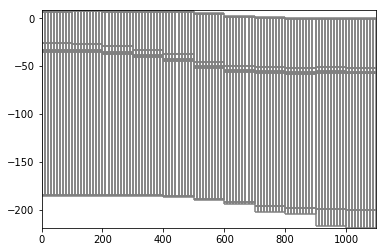

In [10]:
dis = mf.ModflowDis(
    ml, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper, 
    steady=False,
    proj4_str = 'EPSG:31985',
    xul = 292147.853,
    yul = 9105709.477,
    rotation = -16
)

modelxsect= flopy.plot.ModelCrossSection(model=ml, line={'Row':0})
linecollection= modelxsect.plot_grid()

### Setup Basic-Package

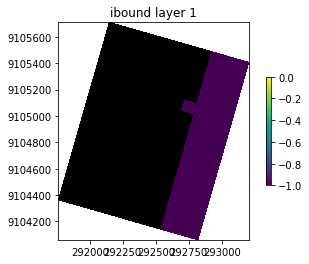

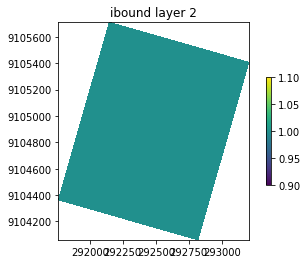

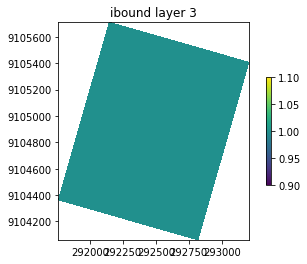

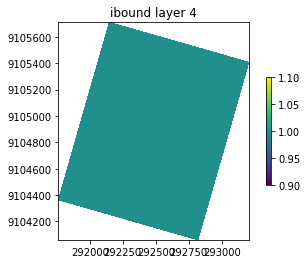

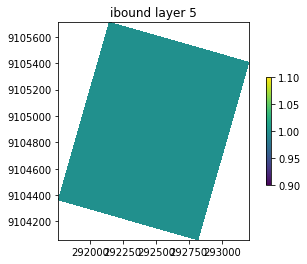

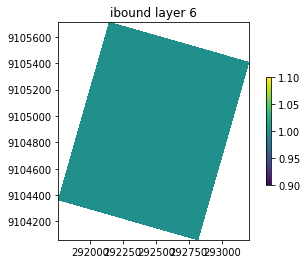

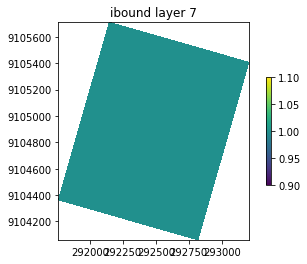

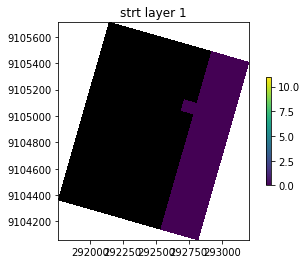

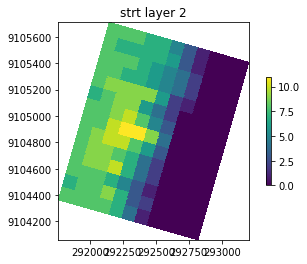

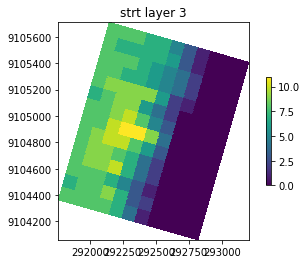

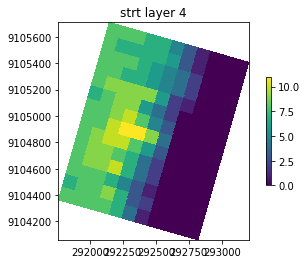

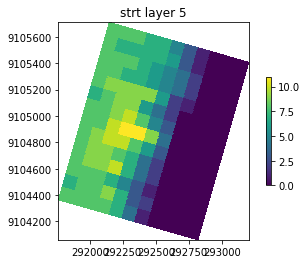

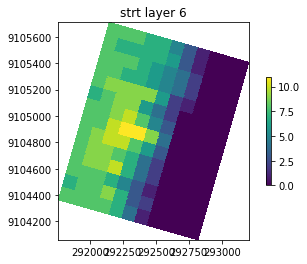

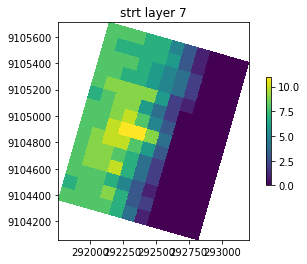

In [11]:
ibound = cbm.bas6.ibound.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
ibound = scale(scaling_factor, ibound)

strt = cbm.bas6.strt.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
strt = scale(scaling_factor, strt)

bas = mf.ModflowBas(ml, ibound=ibound, strt=strt)
bas.plot()

### Setup General Head Boundaries

lets take the start values here and extract the values for each border and layer

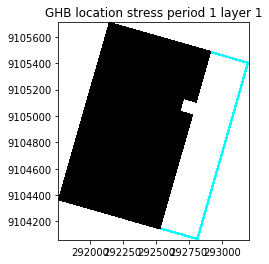

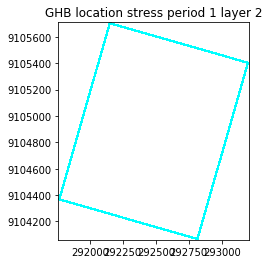

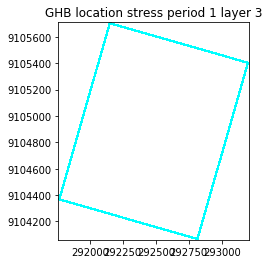

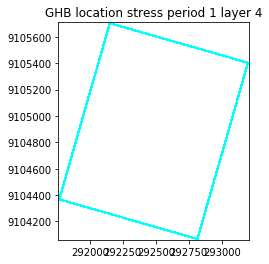

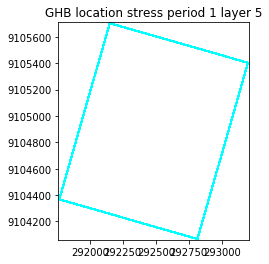

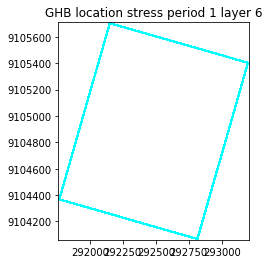

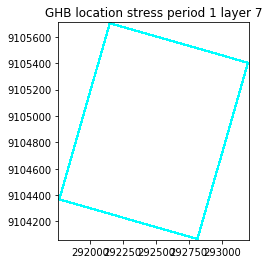

In [12]:
#  [lay, row, col, stage, cond]
mask_arr = np.zeros((nlay, nrow, ncol))
mask_arr[:, 0, :] = 1
mask_arr[:, -1, :] = 1
mask_arr[:, :, 0] = 1
mask_arr[:, :, -1] = 1

hds_old = fu.HeadFile(os.path.join(central_base_model_path, 'model.hds'))
head_old = hds_old.get_data()
head_old = head_old[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
head_old = scale(scaling_factor,head_old)

ghb_spd = {0: []}
for layer_id in range(nlay):
    for row_id in range(nrow):
        for col_id in range(ncol):
            if mask_arr[layer_id][row_id][col_id] == 1:
                ghb_spd[0].append([layer_id, row_id, col_id, head_old[layer_id][row_id][col_id], 5])

ghb = mf.ModflowGhb(ml, stress_period_data=ghb_spd)
ghb.plot()

### Setup Recharge

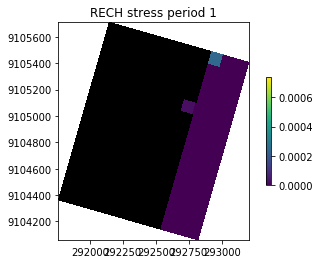

In [13]:
rch = cbm.rch.rech.array[0][:,extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
rch = scale(scaling_factor,rch)
rech = {}
rech[0] = rch
rch = mf.ModflowRch(ml, rech=rech)

rch.plot()

### Setup the well boundary

Add wells here. Load from CSV and calculate layer.

In [14]:
well = pd.read_csv('model_wells_2.csv',delimiter = ',')
well['row'],well['column']
well['Rate[m^3/d']
welSp = {}
welSp[0] = []
for i in range(0,len(well['row'])):
    welSp[0].append([well['LAYER'][i]-1,well['row'][i]-1,well['column'][i]-1,well['Rate[m^3/d'][i]])
wel = mf.ModflowWel(ml, stress_period_data=welSp)

### Setup Flow-Package

In [15]:
bcf = cbm.bcf6

hdry = bcf.hdry
wetfct = bcf.wetfct
ihdwet = bcf.ihdwet
ipakcb = bcf.ipakcb
iwdflg = bcf.iwdflg
iwetit = bcf.iwetit
intercellt = bcf.intercellt
laycon = bcf.laycon
trpy = bcf.trpy


hy = bcf.hy.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
sf1 = bcf.sf1.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
sf2 = bcf.sf2.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
tran = bcf.tran.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
vcont = bcf.vcont.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
wetdry = bcf.wetdry.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]

hy = scale(scaling_factor,hy)
sf1 = scale(scaling_factor,sf1)
sf2 = scale(scaling_factor,sf2)
tran = scale(scaling_factor,tran)
vcont = scale(scaling_factor,vcont)
wetdry = scale(scaling_factor,wetdry)

bcf = mf.ModflowBcf(ml,
                    hdry = hdry, 
                    wetfct = wetfct,
                    ihdwet = ihdwet,
                    ipakcb = ipakcb ,
                    iwdflg = iwdflg,
                    iwetit = iwetit,
                    hy = hy,
                    intercellt = intercellt,
                    sf1 = sf1,
                    sf2 = sf2,
                    tran = tran,
                    trpy = trpy ,
                    vcont = vcont,
                    wetdry = wetdry,
                    laycon = laycon
                   )


### Setup Solver Package and Output-control with defaults

In [16]:
pcg = mf.ModflowPcg(ml,rclose=1e-1)
oc = mf.ModflowOc(ml)

In [17]:
ml.write_input()
ml.run_model()

FloPy is using the following  executable to run the model: C:\Program Files\modflow\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: landelina.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/01/12 12:17:30



(False, [])

### Read output file

In [18]:
hds = fu.HeadFile(os.path.join(landelino_model_path, modelname + '.hds'))
times = hds.get_times()
head = hds.get_data()

IndexError: index 0 is out of bounds for axis 0 with size 0

### Plot output file

In [ ]:
hds.plot(totim=times[-1], colorbar=True, masked_values=[-1e30])

### Comparing the results with the base model

In [ ]:
hds_old.plot(totim=times[-1], colorbar=True, masked_values=[1e30])

In [ ]:
res = head - head_old
for i in range(0,7):
    plt.imshow(res[i])
    plt.title('Layer '+str(i+1))
    plt.colorbar(orientation='vertical')
    plt.show()